In [1]:
import os, sys

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from sklearn.utils.extmath import row_norms
from sklearn.metrics.pairwise import _euclidean_distances


project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

import yace.helpers.evaluation as yace_eval

from yace.run_worker import JobInfo


In [2]:
def get_raw_results(file_paths):
    data_frames = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = job_info_path.parent
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        
        distortions_paths = list(working_dir.glob("distortions*.feather"))
        if len(distortions_paths) == 0:
            continue

        df_perf_data = pd.concat([
            pd.read_feather(file_path)
            for file_path in distortions_paths
        ])
        df_perf_data["experiment_id"] = working_dir.name
        df_perf_data["experiment_name"] = working_dir.parent.name
        df_perf_data["experiment_type"] = experiment_type
        df_perf_data["running_time_secs"] = duration_secs
        
        df_perf_data["algorithm"] = job_info.experiment_params["algorithm_name"]
        df_perf_data["job_info_path"] = job_info_path
        
        for param, val in job_info.experiment_params.items():
            df_perf_data[f"{param}"] = val
        
        data_frames.append(df_perf_data)
    df_data = pd.concat(data_frames)
    return df_data

def add_combined_mean_std(df: pd.DataFrame, attr: str):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.4f} ({std:0.5f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)


In [3]:
job_info_paths  = list(Path("../data/experiments-odin/adv/ss_us_01").glob("**/job-info.json"))
job_info_paths += list(Path("../data/experiments-odin/adv/ss_us_02").glob("**/job-info.json"))
job_info_paths += list(Path("../data/experiments-odin/adv/ss_us_03").glob("**/job-info.json"))
print(f"Number of job files: {len(job_info_paths)}")

Number of job files: 600


In [4]:
df_raw_results = get_raw_results(job_info_paths)
print(f"Number of results: {df_raw_results.shape[0]}")

Number of results: 90000


In [5]:
df_raw_results = df_raw_results[df_raw_results.solution_type == "adv0_33"].copy()
print(f"Number of filtered results: {df_raw_results.shape[0]}")

Number of filtered results: 30000


In [6]:
grouping_cols = ["experiment_name", "epsilon", "k",  "algorithm_name", "solution_type"]
aggregation_spec = dict(
    distortion_mean=("distortion", np.mean),
    distortion_std=("distortion", np.std),
    n_solutions=("distortion", "count")
)
df_grouped = df_raw_results.groupby(grouping_cols).agg(**aggregation_spec).reset_index()
df_grouped

,experiment_name,epsilon,k,algorithm_name,solution_type,distortion_mean,distortion_std,n_solutions
0,ss_us_01,0.01,10,sensitivity-sampling,adv0_33,1.006471,0.005275,250
1,ss_us_01,0.01,10,uniform-sampling,adv0_33,1.004817,0.003963,250
2,ss_us_01,0.01,20,sensitivity-sampling,adv0_33,1.003728,0.002517,250
3,ss_us_01,0.01,20,uniform-sampling,adv0_33,1.002639,0.001880,250
4,ss_us_01,0.01,50,sensitivity-sampling,adv0_33,1.001093,0.000843,250
...,...,...,...,...,...,...,...,...
115,ss_us_03,0.20,50,uniform-sampling,adv0_33,1.008696,0.003348,250
116,ss_us_03,0.20,70,sensitivity-sampling,adv0_33,1.003832,0.002955,250
117,ss_us_03,0.20,70,uniform-sampling,adv0_33,1.003418,0.002201,250
118,ss_us_03,0.20,100,sensitivity-sampling,adv0_33,1.004440,0.002945,250


In [7]:
pd.pivot(
    data=df_grouped,
    index=["epsilon", "k", "experiment_name"],
    columns=["algorithm_name"], 
    values="distortion_mean"
)

algorithm_name               sensitivity-sampling  uniform-sampling
epsilon k   experiment_name                                        
0.01    10  ss_us_01                     1.006471          1.004817
            ss_us_02                     1.005974          1.004785
            ss_us_03                     1.003474          1.002225
        20  ss_us_01                     1.003728          1.002639
            ss_us_02                     1.002043          1.001473
            ss_us_03                     1.001509          1.001055
        50  ss_us_01                     1.001093          1.001172
            ss_us_02                     1.000728          1.000842
            ss_us_03                     1.000519          1.000440
        70  ss_us_01                     1.001034          1.000969
            ss_us_02                     1.000503          1.000582
            ss_us_03                     1.000332          1.000300
        100 ss_us_01                     1.000598          1.000568
            ss_us_02                     1.000378          1.000342
            ss_us_03                     1.000215          1.000184
0.05    10  ss_us_01                     1.033036          1.024607
            ss_us_02                     1.017222          1.012864
            ss_us_03                     1.016349          1.010865
        20  ss_us_01                     1.010197          1.014696
            ss_us_02                     1.008150          1.006489
            ss_us_03                     1.004580          1.005168
        50  ss_us_01                     1.005009          1.004577
            ss_us_02                     1.002843          1.002636
            ss_us_03                     1.001546          1.001900
        70  ss_us_01                     1.002985          1.003045
            ss_us_02                     1.003181          1.002479
            ss_us_03                     1.001225          1.000968
        100 ss_us_01                     1.004137          1.002017
            ss_us_02                     1.001438          1.000949
            ss_us_03                     1.000841          1.001025
0.10    10  ss_us_01                     1.045027          1.049930
            ss_us_02                     1.048852          1.029904
            ss_us_03                     1.029048          1.023680
        20  ss_us_01                     1.017554          1.023119
            ss_us_02                     1.018729          1.019872
            ss_us_03                     1.014281          1.009592
        50  ss_us_01                     1.008216          1.010195
            ss_us_02                     1.005176          1.004205
            ss_us_03                     1.003414          1.004668
        70  ss_us_01                     1.007217          1.004605
            ss_us_02                     1.003443          1.003291
            ss_us_03                     1.001607          1.001446
        100 ss_us_01                     1.003270          1.003869
            ss_us_02                     1.001919          1.002250
            ss_us_03                     1.002041          1.001633
0.20    10  ss_us_01                     1.093509          1.106580
            ss_us_02                     1.088153          1.116748
            ss_us_03                     1.083926          1.040395
        20  ss_us_01                     1.040430          1.070704
            ss_us_02                     1.036374          1.027941
            ss_us_03                     1.024588          1.024335
        50  ss_us_01                     1.019252          1.018823
            ss_us_02                     1.016841          1.005870
            ss_us_03                     1.007018          1.008696
        70  ss_us_01                     1.012478          1.018239
            ss_us_02                     1.004819          1.003366
            ss_us_03                     1.003832       

In [8]:
colors = sns.color_palette("tab10")
colors = sns.color_palette("bright")
algorithms = np.sort(df_raw_results.algorithm_name.unique())[::-1]
algorithm_colors = {algo: colors[i] for i, algo in enumerate(algorithms)}
df_raw_results["k_formatted"] = "$k$=" + df_raw_results["k"].astype(str)
df_grouped["k_formatted"] = "$k$=" + df_grouped["k"].astype(str)

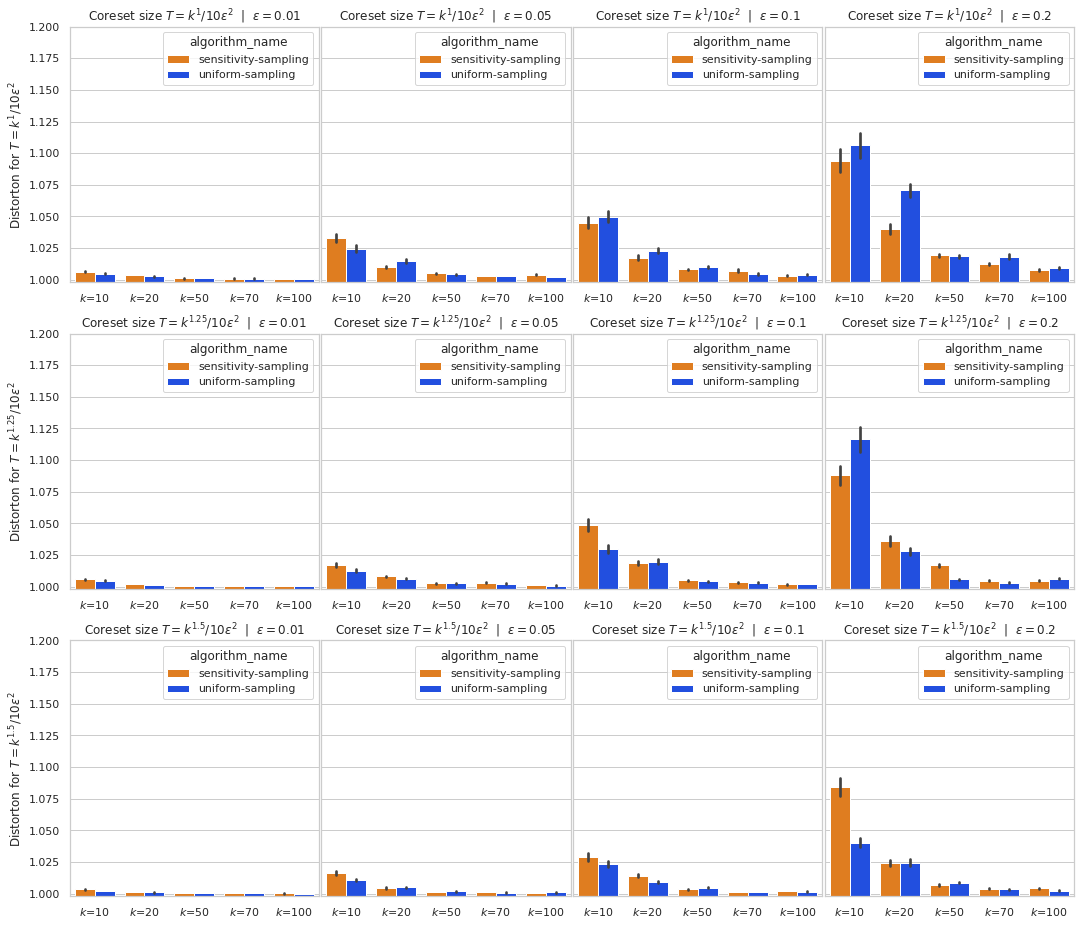

In [9]:
experiment_names = np.sort(df_raw_results["experiment_name"].unique())
epsilons = np.sort(df_raw_results["epsilon"].unique())
n_rows = len(experiment_names)
n_cols = len(epsilons)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(18, 16))

for i, experiment_name in enumerate(experiment_names):
    for j, epsilon in enumerate(epsilons):
        ax = axes[i,j] # axes[i,j]
        f1 = df_raw_results["experiment_name"] == experiment_name
        f2 = df_raw_results["epsilon"] == epsilon
        df_filtered = df_raw_results[f1&f2].copy()
        df_filtered.sort_values(by=["k", "algorithm_name"], inplace=True)
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion", hue="algorithm_name", ax=ax, palette=algorithm_colors)
        ax.set_ylim(bottom=0.998, top=1.2)
        ratio = {"ss_us_01": "1", "ss_us_02": "1.25", "ss_us_03": "1.5"}[experiment_name]
        #s_prime = f"$s'=k^{{{ratio}}}$"
        
        coreset_size = f"$T=k^{{{ratio}}}/10 \\epsilon^2$"
        ax.set_title(f"Coreset size {coreset_size}  |  $\\epsilon={epsilon}$")
        ax.set_ylabel(f"Distorton for {coreset_size}")
        ax.set_xlabel("")
        if j > 0:
            ax.set_ylabel("")            
        if i == 0:
            ax.set_xlabel("")
fig.subplots_adjust(wspace=0.01)
# fig.savefig("distortions-instance-2-varying-coreset-sizes-v3.pdf", )